In [13]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD
from keras.layers import Dropout
from keras.applications.vgg19 import VGG19
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model
from sklearn.metrics import classification_report, confusion_matrix

In [3]:
#Verificamos que tensorflow está usando el gpu
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16488339127399964871
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5723127808
locality {
  bus_id: 1
  links {
  }
}
incarnation: 3942467566013973577
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9"
]


In [5]:
# define cnn model
# load model
model = VGG19(include_top=False, input_shape= (224, 224, 3))
#mark loaded layers as not trainable
for layer in model.layers:
    layer.trainable= False #Con esto le digo al modelo que no entrene las capas del modelo precargado
# add new classifier layers
flat1 = Flatten()(model.layers[-1].output) #Realiza el aplanado de todo el modelo menos de la ultima capa
class1 = Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1)
x = Dropout(0.35)(class1)
output = Dense(22, activation='softmax')(x)
#define new model
model=Model(inputs=model.inputs,outputs=output)
# compile model
opt = SGD(learning_rate=0.0001, momentum=0.9)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()
#plot graph
# MLP=plot_model(model, to_file='model_architecture.svg');
# MLP=plot_model(model, to_file='model_architecture.pdf');


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [6]:
# run the test harness for evaluating a model
# define model
datagen=ImageDataGenerator(featurewise_center=True, width_shift_range=0.1)
# specify imagenet mean values for centering
datagen.mean = [123.68, 116.779, 103.939]
# prepare iterators
train_it = datagen.flow_from_directory('dataset_copia/train/', class_mode='categorical', batch_size=32, target_size=(224, 224))
test_it = datagen.flow_from_directory('dataset_copia/test/', class_mode='categorical', batch_size=32, target_size=(224, 224),shuffle=False)

Found 899 images belonging to 22 classes.
Found 297 images belonging to 22 classes.


In [27]:
# fit model
history = model.fit(train_it, steps_per_epoch=len(train_it), validation_data=test_it, validation_steps=len(test_it), epochs=450, verbose=1)
# evaluate model
_, acc = model.evaluate(test_it, steps=len(test_it), verbose=1)
print('> %.4f' % (acc * 100.0))

Epoch 1/450
29/29 [==============================] - 8s 249ms/step - loss: 0.0754 - accuracy: 0.9711 - val_loss: 0.5014 - val_accuracy: 0.9091
Epoch 2/450
29/29 [==============================] - ETA: 0s - loss: 0.1082 - accuracy: 0.9577

KeyboardInterrupt: 

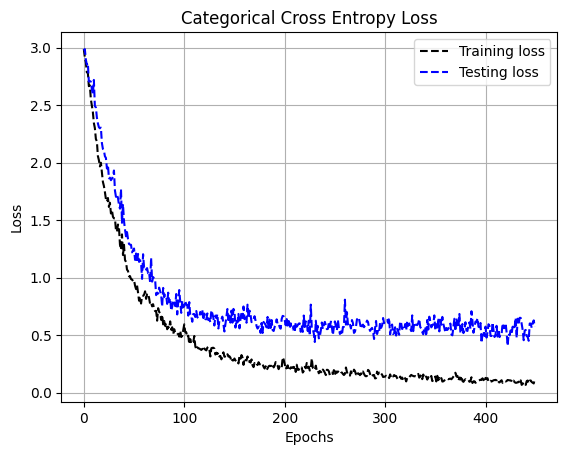

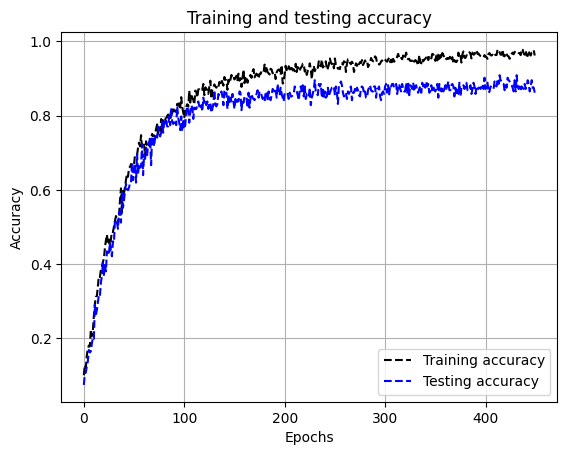

In [10]:
# Learning curves

## Saving the model
# model.save('final_model.hdf5')
# model.save_weights('final_model_weights.h5')
# plot diagnostic learning curves
# plot loss
plt.title('Categorical Cross Entropy Loss')
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'k--', label='Training loss')
plt.plot(epochs, val_loss, 'b--', label='Testing loss')
plt.legend()
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.savefig('loss_function.pdf')
plt.show()
# plot accuracy
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(len(loss))
plt.plot(epochs, accuracy, 'k--', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b--', label='Testing accuracy')
plt.title('Training and testing accuracy')
plt.legend()
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.savefig('Accuracy.pdf')
plt.show()

In [12]:
Y_pred = model.predict(test_it, 297 // 32 +1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(test_it.classes, y_pred))
print('Classification Report')
target_names = ['class 0', 'class 1', 'class 2','class 3','class 4', 'class 5', 'class 6', 'class 7', 'class 8','class 9','class 10','class 11', 'class 12', 'class 13','class 14','class 15', 'class 16', 'class 17', 'class 18', 'class 19','class 20','class 21']
print(classification_report(test_it.classes, y_pred, target_names=target_names))

Confusion Matrix
[[ 9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 20  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 17  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  1 12  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  1  1  0]
 [ 0  0  1  0  9  1  0  0  0  0  1  0  0  0  0  0  0  0  0  0  1  0]
 [ 0  1  0  0  0 15  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  7  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  1  0  9  0  0  0  0  1  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  9  0  0  0  1  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  7  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 11  0  1  1  0  0  0  0  0  0  0  0]
 [ 5  0  0  0  0  0  0  0  0  0  0 13  0  0  4  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0 10  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  1 10  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 

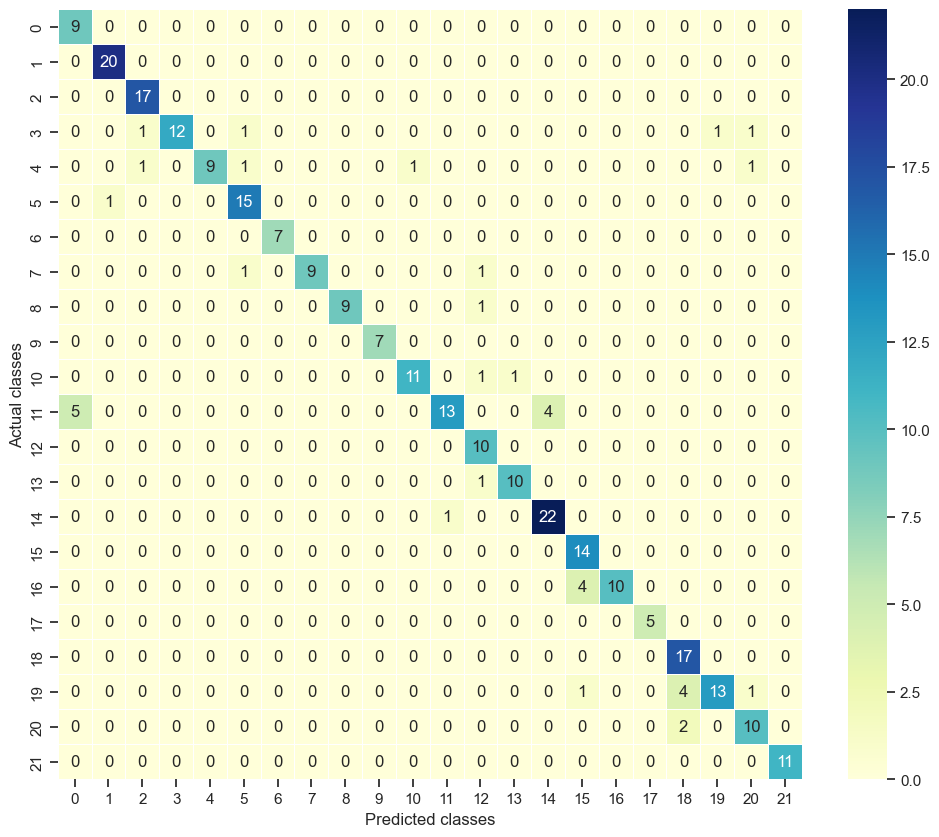

In [16]:
sns.set_theme(style="ticks", color_codes=True)
plt.figure(figsize=(12,10))
cm=confusion_matrix(test_it.classes, y_pred)
sns.heatmap(cm, linewidth=0.5, annot=True, cmap="YlGnBu")
plt.ylabel("Actual classes")
plt.xlabel("Predicted classes")
plt.savefig('confusion_matrix.pdf')


In [17]:
print("Elementos de prueba: {}".format(test_it.classes.shape[0]))
print("Errores identificados: {}".format((test_it.classes != y_pred).sum()))
porcentaje_error = ((test_it.classes != y_pred).sum() * 100) / y_pred.shape[0]
print("Porcentaje de error: {} %".format(porcentaje_error))

Elementos de prueba: 297
Errores identificados: 37
Porcentaje de error: 12.457912457912458 %


In [23]:
test_it

In [18]:
test_it.class_indices

{'1000 Repetitions': 0,
 '10000 Repetitions': 1,
 '11000 Repetitions': 2,
 '12000 Repetitions': 3,
 '13000 Repetitions': 4,
 '14000 Repetitions': 5,
 '15000 Repetitions': 6,
 '16000 Repetitions': 7,
 '17000 Repetitions': 8,
 '18000 Repetitions': 9,
 '19000 Repetitions': 10,
 '2000 Repetitions': 11,
 '20000 Repetitions': 12,
 '28500 Repetitions': 13,
 '3000 Repetitions': 14,
 '4000 Repetitions': 15,
 '5000 Repetitions': 16,
 '6000 Repetitions': 17,
 '7000 Repetitions': 18,
 '8000 Repetitions': 19,
 '9000 Repetitions': 20,
 'Undamaged samples': 21}